# Аннотация куска № 26 генома бактерии

## Дисклеймер

Практически вся работа была выполнена в этом Jupyter Notebook за исключением ряда веб-сервисов и десктопных программ. Этот Notebook одновременно является и отчётом по работе. Все файлы лежат в [этой папке](./) или [zip-архиве](./annotation.zip).

## План работы

1. Данные
2. Программное обеспечение
3. Первичная аннотация генома
4. Аннотация функций продуктов CDS
5. Дополнительный поиск ncRNAs
6. Поиск потенциальных сайтов связывания TF
7. Анализ функций продуктов CDS
8. Обсуждение и впечатления

## 1. Данные

Был получен 21Кб кусок генома бактерии из отряда Thermoanaerobacteriales (класс Clostridia, тип Firmicutes) под кодовым названием strain 3443-3Ac из нового рода.


## 2. Программное обеспечение

В данной работе интенсивно использовалось программное обеспечение. Для воспроизводимости работы приводим таблицу использованного ПО.

Задача | Сервис | Версия | Ссылка
---|---|---|---
Первичная аннотация генома|RAST|NA|[ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3965101/)
Первичная аннотация генома|PROKKA|1.12|[ссылка](https://www.ncbi.nlm.nih.gov/pubmed/24642063)
Аннотация функций CDS|Blast2GO Basic|5.2|[ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2375974/)
Множественное выравнивание|Muscle|3.8.1551|[ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC390337/)
Филогения|PhyML|3.3.20190909|[ссылка](https://www.ncbi.nlm.nih.gov/pubmed/19378142)
Поиск мотивов|FIMO|5.1.1|[ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3065696/)
Поиск ncRNAs|Infernal|NA|[ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2732312/)
Операции с разметками|bedtools|2.29.2|[ссылка](https://www.ncbi.nlm.nih.gov/pubmed/20110278)
Запросы в БД NCBI|entrez-direct|13.3|[ссылка](https://www.ncbi.nlm.nih.gov/books/NBK179288/)
Визуализация геномных отрезков|IGV|2.8.0|[ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3346182/)
Анализ данных|python и пакеты|NA|NA
Среды выполнения|WSL Ubuntu|18.04|NA


Анализ данных вёлся в Python 3 с использованием пакетов numpy, pandas, matplotlib, seaborn и других. Работа велась в специально созданной среде Anaconda. В этой же среде были установлены bedtools, entrez-direct, muscle и phyml. Для воспроизводимости работы прикладываем файл, из которого можно будет сгенерировать среду Anaconda для работы ([файл](./fbb_annotation.yml)).

In [809]:
import re
import os
from collections import Counter
from subprocess import Popen, PIPE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from tqdm.notebook import tqdm
from scipy.stats import binom_test
from IPython.display import Image, display, HTML

from Bio import SeqIO, AlignIO, Phylo

## 3. Первичная аннотация генома

Использовали сервис KBase для аннотации выданного куска генома. В нём использовали аннотаторы PROKKA и RAST. Выгрузили результаты в виде fasta-последовательностей (оказалось, что исходной) и gff-разметок. Ссылка на narrative в KBase, где проводились эти операции, тут: https://narrative.kbase.us/narrative/58095 (необходима регистрация на сервисе для просмотра).

Далее из файла разметок мы взяли записи CDS и вырезали их fasta-последовательности с учётом цепи.

In [310]:
%%bash
grep -e $'\tCDS\t' 26_output_rast.GFF___FASTA/KBase_derived_26_output_rast.gff > 26_output_rast.GFF___FASTA/26.rast_cds.gff
bedtools getfasta -fi 26.fasta -fo 26_output_rast.GFF___FASTA/26.rast_cds.fa -bed 26_output_rast.GFF___FASTA/26.rast_cds.gff -s

In [311]:
%%bash
grep -e $'\tCDS\t' 26_output_prokka.GFF___FASTA/KBase_derived_26_output_prokka.gff > 26_output_prokka.GFF___FASTA/26.prokka_cds.gff
bedtools getfasta -fi 26.fasta -fo 26_output_prokka.GFF___FASTA/26.prokka_cds.fa -bed 26_output_prokka.GFF___FASTA/26.prokka_cds.gff -s

У RAST получилось 25 CDS, у PROKKA получилось 23 CDS. Примечательно, что у PROKKA все CDS были (+), а у RAST одна из CDS распалась на 2: на (-) и на (+) части. У PROKKA потерялась последняя CDS RAST и немного обрезалась с 5'-конца первая CDS RAST. В остальном CDS одинаковые. Обе программы не нашли никаких ncRNA (ни длинных, ни tRNAs, ни rRNAs), не было обнаружено CRIPSR-систем.

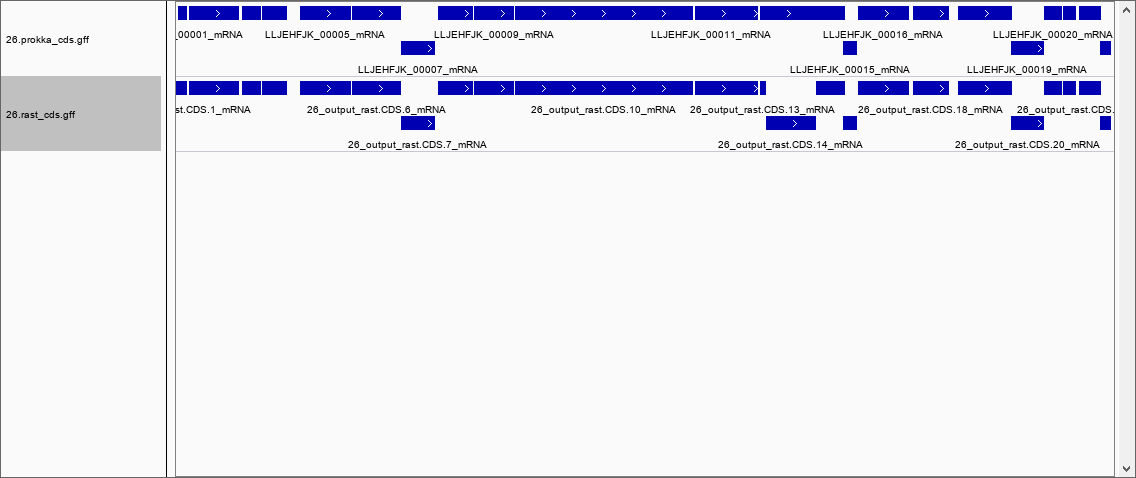

In [294]:
display(Image('two_cds_overview.png'))

In [312]:
%%bash
bedtools jaccard -a 26_output_prokka.GFF___FASTA/26.prokka_cds.gff -b 26_output_rast.GFF___FASTA/26.rast_cds.gff

intersection	union	jaccard	n_intersections
19719	19877	0.992051	18


Коэффициент Жаккара для двух разметок (без учёта цепи) составил 0.992.

Для начала решили использовать аннотацию RAST, так как в нём была одна (-) CDS. 

## 4. Аннотация функций продуктов CDS

Для аннотации функций использовали Blast2GO 5.2 Basic. Его пайплайн таков:

1. Загруженные последовательности бластуются;
2. Для каждой последовательности сохраняются все хиты BLAST и их GO terms;
3. Название последовательности аннотируется исходя из описаний хитов BLAST;
4. К каждой последовательности приписываются GO terms исходя из GO terms их хитов BLAST;
5. Дополнительно последовательности прогоняются через InterPro Scan (CDD, HAMAP, HMMPANTHER, HMMPfam, HMMPIR, FPrintScan, BlastProDom) и кучу других сервисов:
    1. Семейства и домены: ProfileScan (PROSITE), HMMSmart (SMARTS), HMMTigr (TIGRFAM), PatternScan (PROSITE);
    2. Структурные домены: Gene3D, SuperFamily, SFLD;
    3. Предсказание элементов последовательностей: Coils (coiled coil), MobiDBLite (IDR), Phobius (TM и сигнальные последовательности), SignalPHMM (сигнальные последовательности), TMHMM (TM));
6. Затем GO-аннотации из BLAST и InterPro сливаются с помощью Annex;
7. По GO-аннотации дополняются EC и названия ферментов, если они есть.

Параметры для всех программ были поставлены по-умолчанию, кроме BLAST: использовался blastx, гонялся против базы nr в пределах Bacteria.

Сначала в этот пайплайн загрузили аннотацию RAST. Оказалось, что для той самой (-) CDS не нашлось находок в BLAST на дефолтном E-value < 1E-3. Тогда решили использовать аннотацию PROKKA &mdash; она показалась более правдивой. 

### 4.1. Таксономия хитов BLAST

Для каждой CDS были найдены хиты BLAST, каждая CDS была проаннотирована неким названием из описаний хитов BLAST. Для определения того, есть ли горизонтальный перенос в данном куске генома, были получены списки видов, к которым относятся хиты BLAST.

#### 4.1.1. Выделение видов, из которых пришли хиты

Результаты поиска BLAST пришли в zip-архивах, которые содержали .xml-файлы с выдачей.

In [585]:
%%bash
ls blast2go/prokka_results/blast_searches/

7KWTNHVG014.zip
7KWTUMWJ016.zip
7KWTYK7D016.zip
7KWU41NN014.zip
7KWU8U12014.zip
7KWUCP05014.zip
7KWUGSNP016.zip
7KWUNVSS016.zip
7KWUU3Z1016.zip
7KWUY4T0016.zip
7KXJ85YC016.zip
7KXJDJFE016.zip
7KXTB8XH014.zip
7KXTFVPK016.zip
7KXWKBXC014.zip
7KXWR9M1014.zip
7KXX7RKH016.zip
7KXXBPEH016.zip
7KY110AK014.zip
7KY16SRN014.zip
7KY7JH57016.zip
7KYC453M014.zip
7KZ23X58016.zip


Мы распаковали эти файлы и выбрали те, которые содержат информацию о выравниваниях.

In [592]:
%%bash
unzip "blast2go/prokka_results/blast_searches/*" -d blast2go/prokka_results/blast_searches/

Archive:  blast2go/prokka_results/blast_searches/7KWTNHVG014.zip
  inflating: blast2go/prokka_results/blast_searches/7KWTNHVG014.xml  
  inflating: blast2go/prokka_results/blast_searches/7KWTNHVG014_1.xml  

Archive:  blast2go/prokka_results/blast_searches/7KWTUMWJ016.zip
  inflating: blast2go/prokka_results/blast_searches/7KWTUMWJ016.xml  
  inflating: blast2go/prokka_results/blast_searches/7KWTUMWJ016_1.xml  

Archive:  blast2go/prokka_results/blast_searches/7KWTYK7D016.zip
  inflating: blast2go/prokka_results/blast_searches/7KWTYK7D016.xml  
  inflating: blast2go/prokka_results/blast_searches/7KWTYK7D016_1.xml  

Archive:  blast2go/prokka_results/blast_searches/7KWU41NN014.zip
  inflating: blast2go/prokka_results/blast_searches/7KWU41NN014.xml  
  inflating: blast2go/prokka_results/blast_searches/7KWU41NN014_1.xml  

Archive:  blast2go/prokka_results/blast_searches/7KWU8U12014.zip
  inflating: blast2go/prokka_results/blast_searches/7KWU8U12014.xml  
  inflating: blast2go/prokka_resu


23 archives were successfully processed.


Интересующие нас файлы имеют название, оканчивающееся на `_1.xml`. Выберем их, будем из них выделять название отправленной последовательности и научные названия организмов, из которых пришли хиты.

In [595]:
hit_files = [filename for filename in os.listdir('blast2go/prokka_results/blast_searches/') if filename.endswith('_1.xml')]

In [604]:
cds_species = dict()
for fname in hit_files:
    with open(f'blast2go/prokka_results/blast_searches/{fname}', 'r') as infile:
        contents = infile.read()
        query = re.findall(r'<query-title>(.+)</query-title>', contents)
        hit_species = re.findall(r'<sciname>(.+)</sciname>', contents)
        cds_species[query[0]] = hit_species

#### 4.1.2. Определение таксономии видов из хитов

Теперь для каждой CDS мы найдём таксономический состав хитов (тип, класс, порядок). Семейство и род нас не будут интересовать, так как наш сказали, что наш штамм относится к новому роду внутри порядка Thermoanaerobacteriales (Clostridia/Firmicutes).

Для этого мы воспользуемся сервисом edirect. Напишем шаблон строки запроса, которая для каждого вида будет вытаскивать его таксономические ранги.

In [607]:
equery_string = 'esearch -db Taxonomy -query "{}" | efetch -format xml | ' \
                 'xtract -pattern Taxon ' \
                 '-block "*/Taxon" -tab ";" -element Rank,ScientificName'

Создадим объект, в который будем складывать данные по таксономии.

In [609]:
cds_taxonomy = dict()

Итерируемся по строкам датафрейма и для каждого вида каждой cds находим его тип, класс, порядок.

In [610]:
for cds, species_list in tqdm(cds_species.items()):
    taxonomy = {'phylum': Counter(),
                'class': Counter(),
                'order': Counter()}
    for species in tqdm(species_list):
        with Popen(equery_string.format(species), shell=True, stdout=PIPE, stderr=PIPE) as p:
            stdout, stderr = p.communicate()
            result = stdout.decode()
            for species_result in result.split('\n'):
                if len(species_result) == 0:
                    break
                lineage = species_result.split(';')
                lineage = dict([item.split('\t') for item in lineage])
                for key in taxonomy.keys():
                    taxonomy[key].update([lineage.get(key)])
    cds_taxonomy[cds] = taxonomy

Теперь преобразуем результаты в датафрейм.

In [611]:
cds_taxonomy_for_df = list()
for cds, taxonomy in cds_taxonomy.items():
    for rank, counter in taxonomy.items():
        for taxon, count in counter.items():
            cds_taxonomy_for_df.append({'Seq': cds,
                                        'Rank': rank,
                                        'Taxon': taxon,
                                        'Count': count})

In [615]:
cds_taxonomy_df = pd.DataFrame.from_records(cds_taxonomy_for_df)

In [624]:
cds_taxonomy_df.head()

Seq    Rank                   Taxon  Count
0  CDS_strain_56-275(plus)  phylum              Firmicutes     30
1  CDS_strain_56-275(plus)   class              Clostridia     29
2  CDS_strain_56-275(plus)   class                    None      1
3  CDS_strain_56-275(plus)   order  Thermoanaerobacterales     16
4  CDS_strain_56-275(plus)   order           Clostridiales     13

Сохраним результаты, так как мы долго их получали.

In [625]:
cds_taxonomy_df.to_csv('prokka_blast_taxonomy.tsv', header=True, index=False, sep='\t')

Построим распределение таксонов хитов BLAST для каждой CDS. Сначала подберём нужную цветовую палитру, потому что у нас есть много записей, а по-умолчанию палитра для такого количества некрасивая.

In [618]:
divergent_palette = [tuple(value - 0.2 for value in block) for block in sns.color_palette('Set3')]

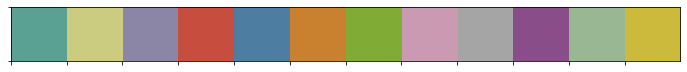

In [620]:
sns.palplot([tuple(value - 0.2 for value in block) for block in sns.color_palette('Set3')])

А теперь построим графики.

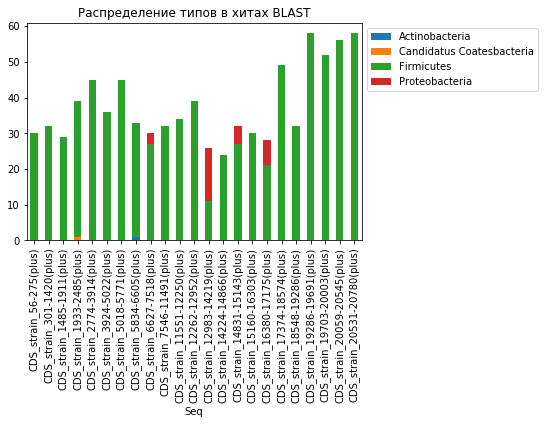

In [859]:
cds_taxonomy_df.query('Rank == "phylum"') \
.pivot_table(index=['Seq'], columns=['Taxon'], values='Count') \
.loc[cds_taxonomy_df['Seq'].unique(), :] \
.plot(kind='bar', stacked=True)
plt.title("Распределение типов в хитах BLAST")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

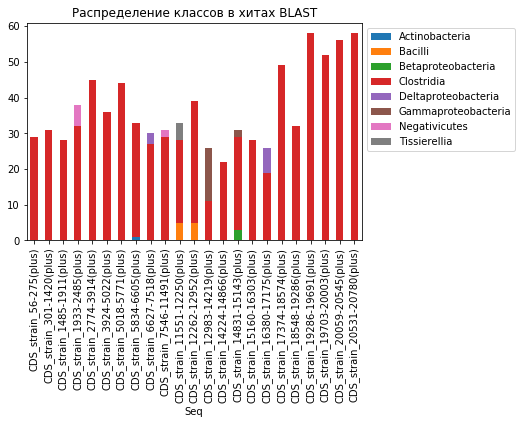

In [860]:
cds_taxonomy_df.query('Rank == "class"') \
.pivot_table(index=['Seq'], columns=['Taxon'], values='Count') \
.loc[cds_taxonomy_df['Seq'].unique(), :] \
.plot(kind='bar', stacked=True)
plt.title("Распределение классов в хитах BLAST")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

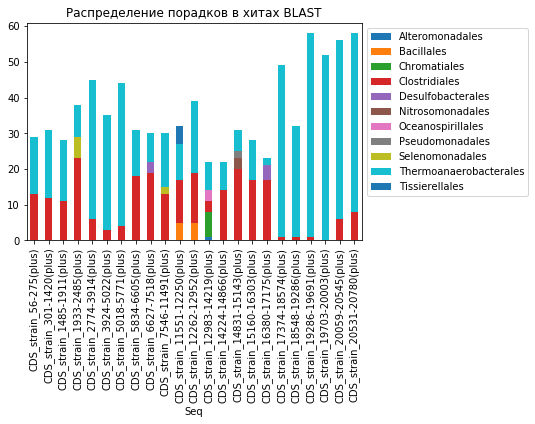

In [861]:
cds_taxonomy_df.query('Rank == "order"') \
.pivot_table(index=['Seq'], columns=['Taxon'], values='Count') \
.loc[cds_taxonomy_df['Seq'].unique(), :] \
.plot(kind='bar', stacked=True)
plt.title("Распределение порадков в хитах BLAST")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Практически у всех CDS хиты BLAST пришли из порядка Clostridia (из семейств Thermoanareobacterales и Clostridiales). Подозрение о горизонтальном переносе вызывает рамка CDS_strain_12983_14219(plus) &mdash; у её хитов больше представителей Proteobacteria, чем Firmicutes, и Gammaproteobacteria, чем Clostridia, соответственно. По составу семейств в ней преобладают Thermoanaerobacterales (наше целевое семейство) и Chromatiales (Gammaproteobacteria), которые встречаются только у этой рамки.

Посмотрим на расположение этой CDS в геноме. Напоминаем, что это CDS 13 в PROKKA и именно эта CDS была разбита на две в RAST.

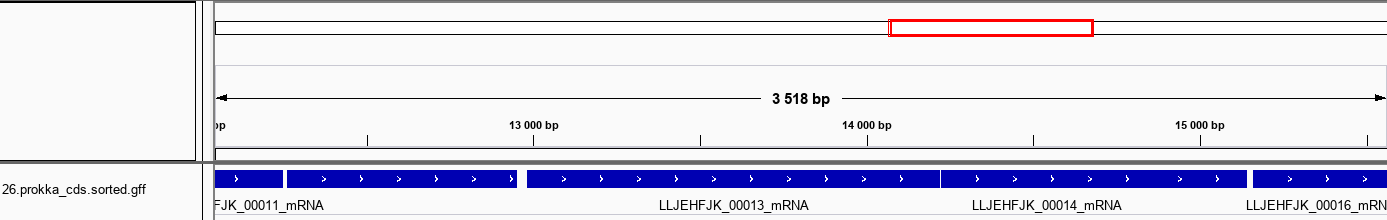

In [674]:
display(Image('cds_13_location.png'))

CDS 13 плотно окружена генами, в которых мы не сомневаемся, что они не были принесены горизонтальным переносом. Кажется, что в таком геномном окружении не могло быть горизонтального переноса. Проверим это с помощью построения дерева по множественному выравниванию аминокислотной последовательности CDS 13 и её хитов BLAST.

#### 4.1.3. Определение горизонтального переноса для CDS 13

Сначала загрузим последовательность CDS 13 и транслируем её в белок.

In [684]:
target_cds_name = "strain:12983-14219(+)"
prokka_cds = list(SeqIO.parse('26_output_prokka.GFF___FASTA/26.prokka_cds.fa', format='fasta'))
target_cds = [cds for cds in prokka_cds if cds.id == target_cds_name][0]

In [687]:
target_cds

SeqRecord(seq=Seq('GTGTTAAAATATCAAAAAATCAGTATAAAATTAATATTTGTTTTTGTTCTTGCA...TGA', SingleLetterAlphabet()), id='strain:12983-14219(+)', name='strain:12983-14219(+)', description='strain:12983-14219(+)', dbxrefs=[])

У нашей CDS альтернативный старт-кодон.

In [689]:
target_protein = target_cds.translate(table=11, to_stop=True, cds=True)

In [694]:
target_protein.id = 'CDS_13'
target_protein.name = 'CDS_13'

Теперь нам надо выделить из xml-файла хитов BLAST названия последовательностей для хитов BLAST. А сначала надо найти соответствующий файл.

In [721]:
target_cds_blast = "CDS_strain_12983-14219(plus)"

In [729]:
cds_for_re = target_cds_blast.replace("(", "\(").replace(")", "\)")

In [759]:
for fname in hit_files:
    with open(f'blast2go/prokka_results/blast_searches/{fname}', 'r') as infile:
        contents = infile.read()
        if re.search(rf'{cds_for_re}', contents) is not None:
            target_blast_filename = fname

In [734]:
target_blast_filename

'7KXTB8XH014_1.xml'

Теперь из этого файла вычленим идентификаторы последовательностей хитов.

In [765]:
hit_acc = list()
with open(f'blast2go/prokka_results/blast_searches/{target_blast_filename}', 'r') as infile:
    search_start = True
    search_acc = False
    for line in infile:
        if search_start:
            if re.search(r'<description>', line) is not None:
                search_start = False
                search_acc = True
        if search_acc:
            match = re.search(r'<accession>(.+)<\/accession>', line)
            if match is not None:
                search_start = True
                search_acc = False
                hit_acc.append(match[1])

In [766]:
hit_acc

['WP_158506589',
 'AIS51712',
 'KUK30936',
 'WP_015051549',
 'HAA89383',
 'WP_083774295',
 'WP_084413486',
 'WP_107753657',
 'WP_133734802',
 'WP_095616436',
 'WP_019640868',
 'WP_151440789',
 'WP_017942373',
 'WP_143512784',
 'WP_163141523',
 'WP_028484127',
 'MAL98148',
 'WP_018719071',
 'OOC09946',
 'WP_019591167']

Теперь для каждого Accession вытащим его последовательность и добавим к общему набору последовательностей.

In [786]:
protein_records = SeqIO.FastaIO.as_fasta(target_protein)

In [787]:
esearch_fasta = 'esearch -db protein -query "{}" | efetch -format fasta'

In [788]:
for acc in tqdm(hit_acc):
    with Popen(esearch_fasta.format(acc), stdout=PIPE, stderr=PIPE, shell=True) as p:
        record = p.communicate()[0].decode()
        if record:
            protein_records += record

Теперь сделаем множественное выравнивание последовательностей с помощью MUSCLE (с настройками по-умолчанию).

In [803]:
with Popen("muscle -out cds_13_alignment.aln -clw", stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True) as p:
    p.communicate(protein_records.encode())

Прочитаем выравнивание в формате Clustal и сохраним выравнивание в формате Phylip.

In [805]:
cds_alignment = AlignIO.read('cds_13_alignment.aln', format='clustal')

In [808]:
AlignIO.write(cds_alignment, 'cds_13_alignment.phylip', format='phylip')

1

Для построения дерева воспользуемся пакетом PhyML (использует алгоритм наибольшего правдоподобия, с настройками по-умолчанию (модель замен LG, оптимизация ветвей NNI), бутстрэп 100).

In [818]:
with Popen("phyml -i cds_13_alignmeesearch_fasta.phylip -d aa -b 100", shell=True) as p:
    p.communicate()

In [819]:
cds_tree = Phylo.read("cds_13_alignment.phylip_phyml_tree.txt", format='newick')

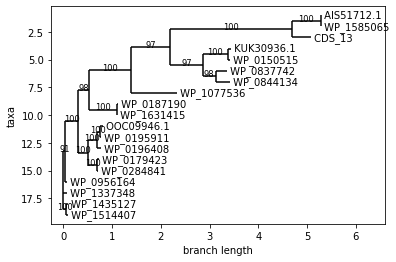

In [820]:
Phylo.draw(cds_tree)

Ура, получилось дерево! Очень хорошая поддержка ветвей по bootstrap. Но по accession белков непонятна таксономия. Давайте её вытащим и раскрасим ветви соответственно таксону.

In [821]:
esearch_protein_taxon_template = 'esearch -db protein -query "{}" | elink -target Taxonomy | efetch -format xml | xtract -pattern Taxon -block "*/Taxon" -tab ";" -element Rank,ScientificName'

In [840]:
acc_taxons = dict()
for clade in tqdm(cds_tree.get_terminals()):
    acc = clade.name
    if acc == 'CDS_13':
        continue
    with Popen(esearch_protein_taxon_template.format(acc), stdout=PIPE, stderr=PIPE, shell=True) as p:
        stdout, stderr = p.communicate()
        result = stdout.decode()
        for species_result in result.split('\n'):
            if len(species_result) == 0:
                break
            lineage = species_result.split(';')
            lineage = dict([item.split('\t') for item in lineage])
            for key in taxonomy.keys():
                taxonomy[key].update([lineage.get(key)])
        
        acc_taxons[acc] = dict([(rank, lineage.get(rank)) for rank in ['phylum', 'class', 'order', 'genus']])

In [844]:
phylum_colors = {'Firmicutes': 'blue',
                 'Proteobacteria': 'red',
                 None: 'black'}

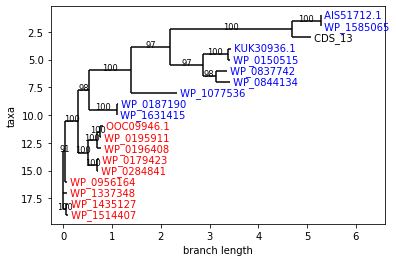

In [845]:
Phylo.draw(cds_tree, label_colors=lambda label: phylum_colors.get(acc_taxons.get(label, dict()).get('phylum')))

Синим покрашены Firmicutes, а красным &mdash; Proteobacteria. Как мы видим, наша CDS кластеризуется с Firmicutes, а значит, у нас нет горизонтального переноса.

#### 4.1.4. Общее распределение видов по хитам BLAST

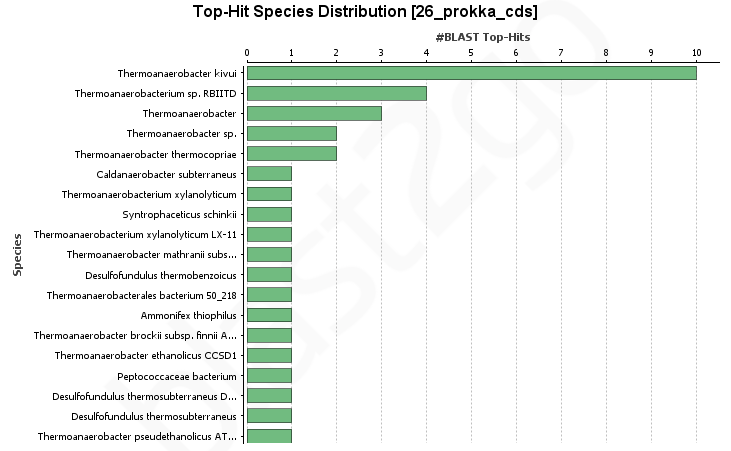

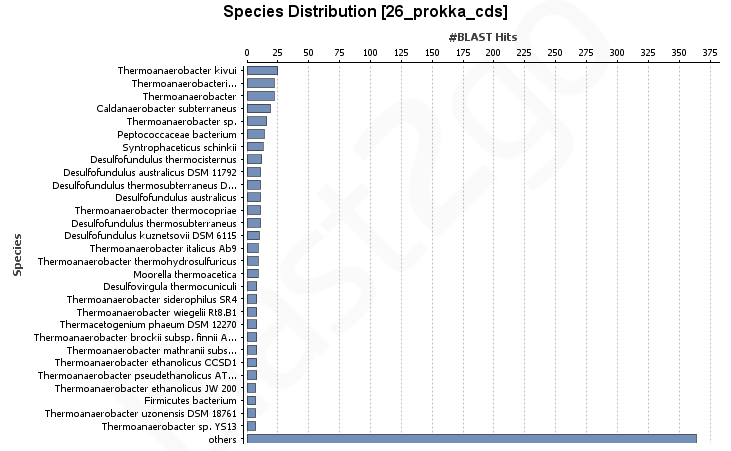

In [847]:
display(Image('blast2go/prokka_results/top_hit_species_distribution.png'),
        Image('blast2go/prokka_results/species_distribution.png'))

В топе всех видов и видов наилучших хитов находятся представители родов _Thermoanaerobacter_ и _Thermoanaerobacterium_. Больше всего хитов у вида _Thermoanaerobacter kivui_. Можно ещё посмотреть на распределение процентов схожести последовательностей.

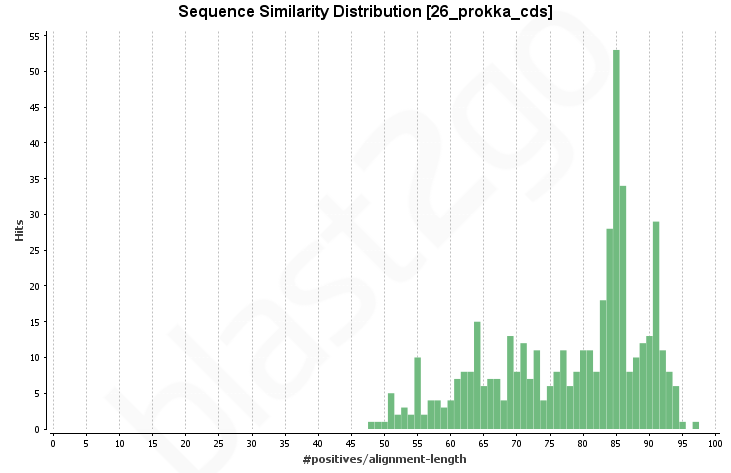

In [848]:
display(Image('blast2go/prokka_results/similarity_distribution.png'))

Вроде ок, довольно неплохое сходство. А вот распределение e-value оказалось неровным.

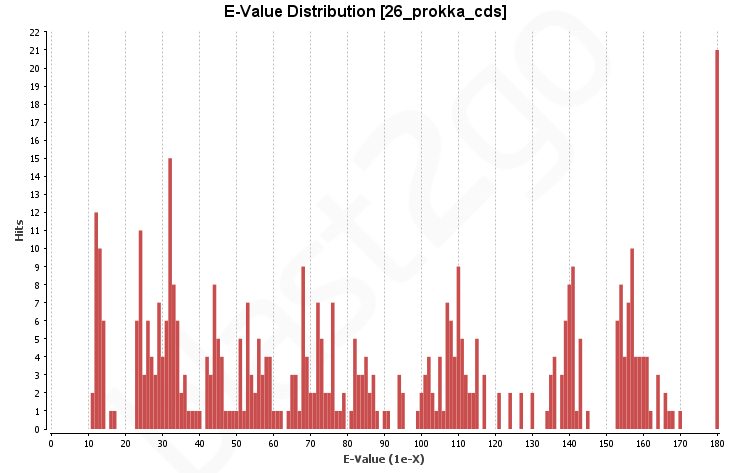

In [851]:
display(Image('blast2go/prokka_results/eval_distribution.png'))

### 4.2. Определение GO terms на основе хитов BLAST

Нажали кнопку "Mapping", и Blast2GO собрал аннотации наших CDS в GO. Для 20 последовательностей удалось вывести GO terms.

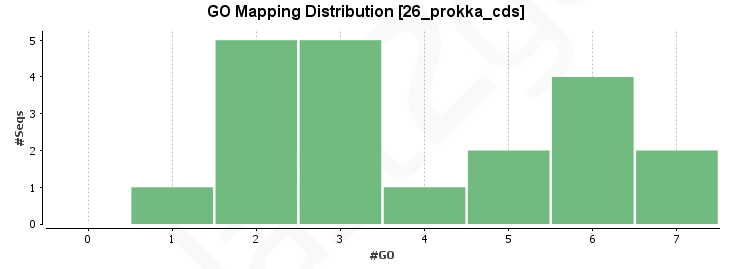

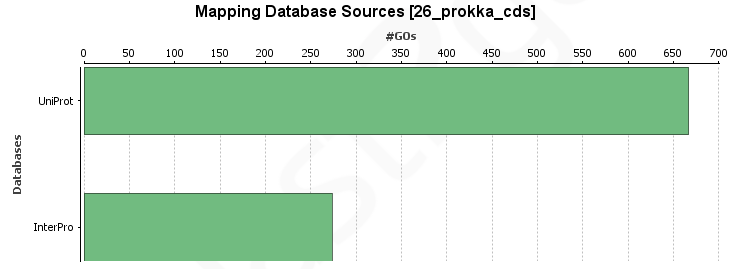

In [849]:
display(Image('blast2go/prokka_results/go_mapping_distribution.png'),
        Image('blast2go/prokka_results/go_mapping_sources.png'))

Из тех 20 последовательностей у 19 больше 1 GO term. Аннотация преимущественно пришла из UniProt, чем из данных InterPro.

### 4.3. Аннотация функций и GO terms с помощью InterPro Scan

Запустили InterPro Scan. Для всех 23 последовательностей InterPro Scan что-то нашёл и/или предсказал, а ещё для 8 он нашёл GO terms.

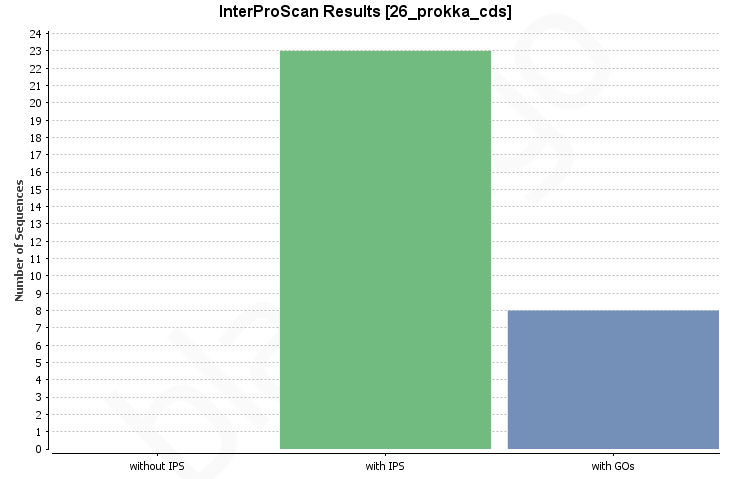

In [850]:
display(Image('blast2go/prokka_results/interpro_results.png'))

### 4.4. Слияние приписанных GO terms и аннотация функций

Приписанные GO terms из BLAST затем умным способом аггрегируются и на их основе выводятся конечные GO terms и даже EC. Добавление GO terms из InterPro не увеличило число GO terms, зато подтвердило многие GO terms из InterPro.

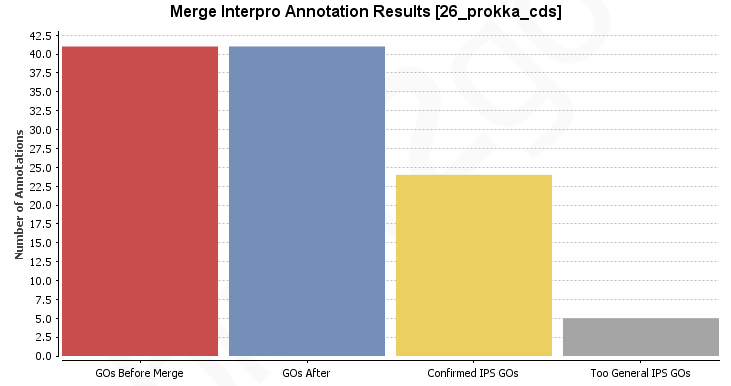

In [853]:
display(Image('blast2go/prokka_results/merge_interpro_go_results.png'))

Зато аугментация аннотации с помощью Annex смогла добавить новые аннотации.

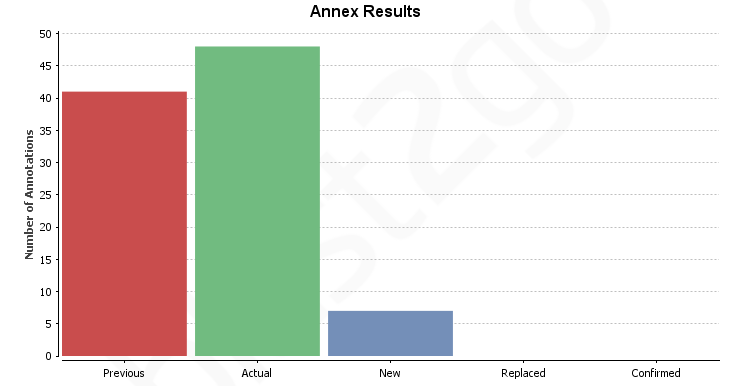

In [854]:
display(Image('blast2go/prokka_results/annex_results.png'))

Итоговое распределение GO terms по генам ниже.

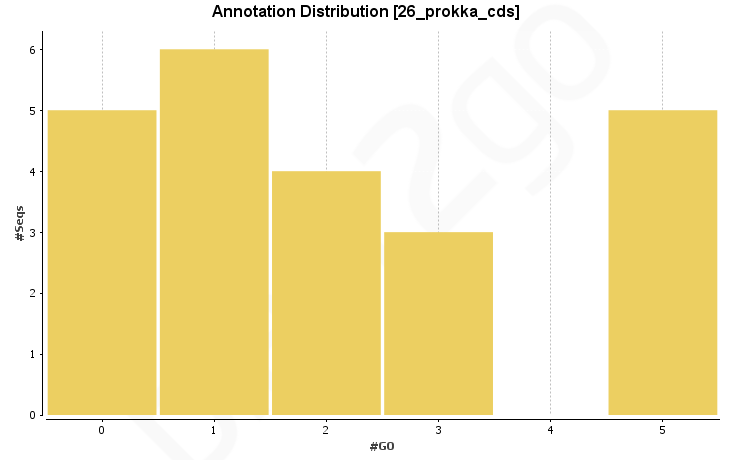

In [852]:
display(Image('blast2go/prokka_results/go_annotation_distribution.png'))

Для 5 последовательностей не удалось вывести итоговые GO terms. Итоговое распределение CDS по степени аннотированности выглядит так:

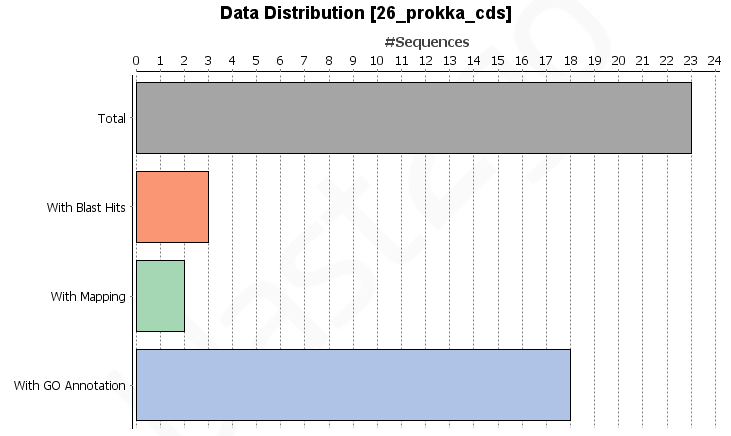

In [862]:
display(Image('blast2go/prokka_results/data_dist.png'))

На самом деле, как мы увидим в разделе 7, для всех CDS что-то да нашлось в InterPro Scan, а название белка удалось вывести из хитов BLAST.

## 5. Дополнительный поиск ncRNAs

Для дополнительного поиска ncRNAs мы использовали программу `cmscan` из пакета Infernal, доступного онлайн (https://www.ebi.ac.uk/Tools/rna/infernal_cmscan/). Туда мы загрузили последовательность куска генома целиком и использовали параметры поиска по-умолчанию. Программа не нашла никаких совпадений из базы Rfam ([вывод программы](./cmscan.txt)).

## 6. Поиск потенциальных мест связывания TF

Для поиска мотивов связывания TF мы использовали FIMO из MEME-suite (онлайн). Использовали базы данных мотивов прокариот CollecTF, Prodoric и RegTransBase. Искали в полной последовательности куска генома. Использовали параметры по-умолчанию (p-value < 1E-4 и сканирование обеих цепей ДНК).

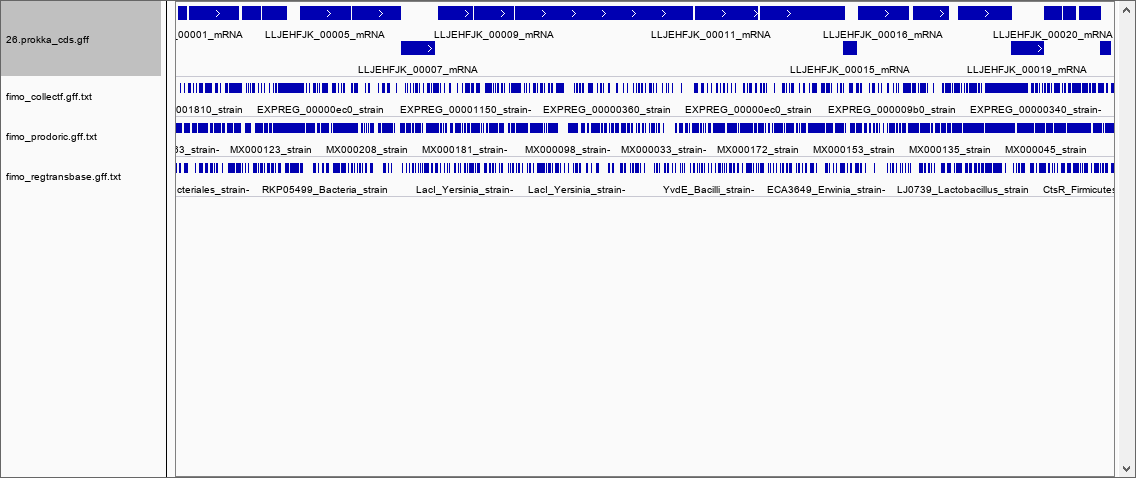

In [317]:
display(Image('motifs_full.png'))

Были найдены тысячи попаданий мотивов! И это несмотря на то, что была коррекция на множественное тестирование. Видимо, надо контролировать не только p-value, но и q-value для каждого мотива.

### 6.1. Отбор порога для мотивов связывания

Загрузим разметки мотивов.

In [313]:
collectf = pd.read_csv('motif_search/fimo_collectf.tsv', header=[0], index_col=None, sep='\t')
prodoric = pd.read_csv('motif_search/fimo_prodoric.tsv', header=[0], index_col=None, sep='\t')
regtransbase = pd.read_csv('motif_search/fimo_regtransbase.tsv', header=[0], index_col=None, sep='\t')

Переименуем названия некоторых столбцов под валидные.

In [352]:
collectf.columns = ['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand', 'score', 'p_value', 'q_value', 'matched_sequence']
prodoric.columns = ['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand', 'score', 'p_value', 'q_value', 'matched_sequence']
regtransbase.columns = ['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand', 'score', 'p_value', 'q_value', 'matched_sequence']

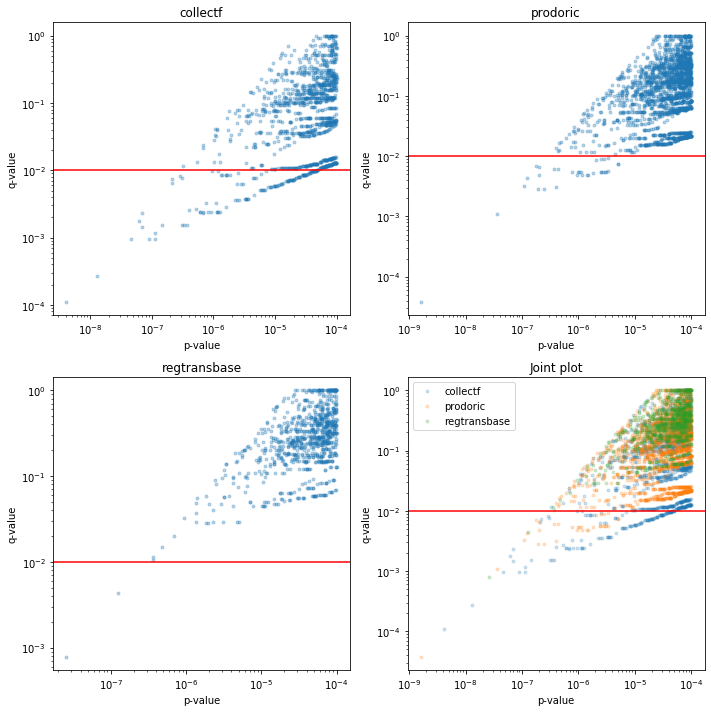

In [353]:
plt.figure(figsize=(10, 10))
for i, motif_source in enumerate(zip((collectf, prodoric, regtransbase),
                                     ('collectf', 'prodoric', 'regtransbase'))):
    plt.subplot(2, 2, i + 1)
    motif_data, source_name = motif_source
    plt.plot(motif_data['p_value'], motif_data['q_value'], '.', alpha=.3)
    plt.title(source_name)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('p-value')
    plt.ylabel('q-value')
    plt.axhline(1e-2, color='red')
plt.subplot(2, 2, 4)
for motif_source in zip((collectf, prodoric, regtransbase),
                        ('collectf', 'prodoric', 'regtransbase')):
    motif_data, source_name = motif_source
    plt.plot(motif_data['p_value'], motif_data['q_value'], '.', alpha=.2, label=source_name)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p-value')
plt.ylabel('q-value')
plt.axhline(1e-2, color='red')
plt.title('Joint plot')
plt.legend()
plt.tight_layout()

Решили оставить порог p-value 1e-4, а для q-value (FDR) решили взять порог 1e-2.

In [330]:
qval_thresh = 1e-2

In [331]:
for motif_source in ['collectf', 'prodoric', 'regtransbase']:
    with open(f'motif_search/fimo_{motif_source}.gff.txt', 'r') as infile:
        with open(f'motif_search/fimo_{motif_source}_qvalue_{qval_thresh:1.0E}.gff', 'w') as outfile:
            for line in infile:
                if line.startswith('#'):
                    outfile.write(line)
                matching = re.search(r'qvalue=(\d+\.\d+)', line)
                if matching is not None:
                    qvalue = float(matching[1])
                    if qvalue < qval_thresh:
                        outfile.write(line)

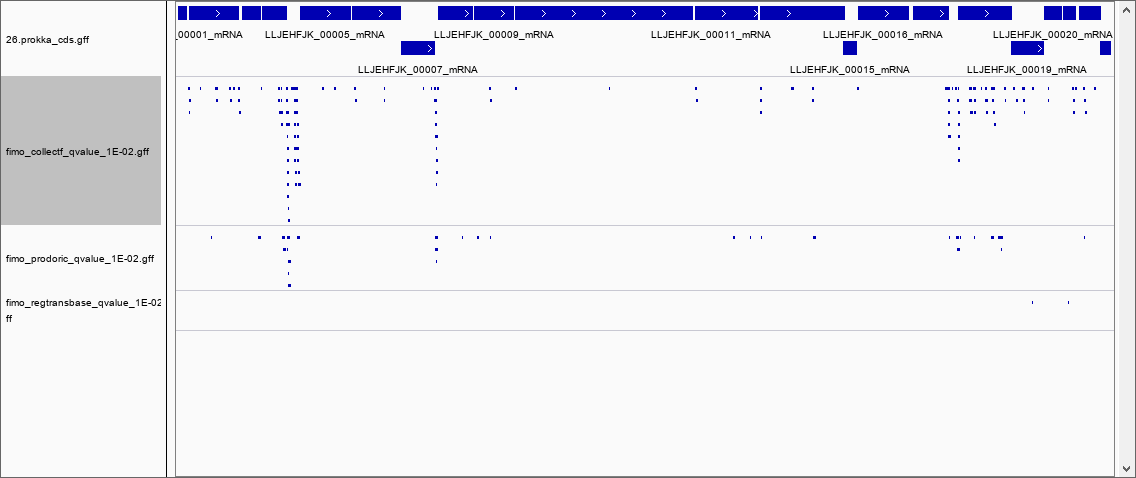

In [332]:
display(Image('motifs_qvalue_1E-02.png'))

Уже значительно лучше. Кажется, что мотивы концентрируются вокруг начала CDS. Но всё равно как-то избыточно. Давайте поставим порог q-value в 5E-3 и посмотрим, что получится.

In [328]:
qval_thresh = 5e-3

In [329]:
for motif_source in ['collectf', 'prodoric', 'regtransbase']:
    with open(f'motif_search/fimo_{motif_source}.gff.txt', 'r') as infile:
        with open(f'motif_search/fimo_{motif_source}_qvalue_{qval_thresh:1.0E}.gff', 'w') as outfile:
            for line in infile:
                if line.startswith('#'):
                    outfile.write(line)
                matching = re.search(r'qvalue=(\d+\.\d+)', line)
                if matching is not None:
                    qvalue = float(matching[1])
                    if qvalue < qval_thresh:
                        outfile.write(line)

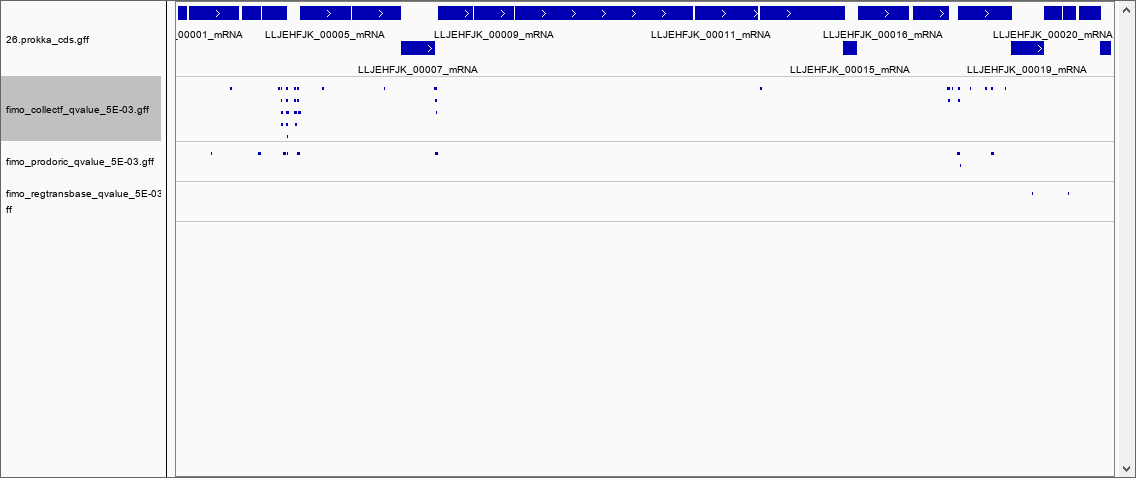

In [333]:
display(Image('motifs_qvalue_5E-03.png'))

Мотивы стали более выраженно размещаться рядом с началами CDS.

### 6.2. Колокализация мотивов и начал CDS

Для того, чтобы проверить гипотезу о колокализации начал CDS и мотивов, мы использовали точный тест Фишера в `bedtools fisher`. В качестве участков начал CDS мы взяли отрезки [-200, 100] от начала каждой CDS (согласуется с [этой статьёй](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1950076/), правда, там были TSS). Тест Фишера в bedtools помогает определить, насколько значимо перекрывание (или наоборот, избегание) наборов двух отрезков. Ввиду того, что мы не знаем ничего о предпочтениях TF той или иной цепи ДНК (вообще, она бывает разная, но в общем её нет: [статья 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4778318/), [статья 2](https://www.nature.com/articles/nature28170) на эукариотах), то мы будем считать пересечения отрезков как одной цепи, так и разных (мотивы обнаруживались как  на "+", так и на "-" цепях.

#### 6.2.1. Оценка предпочтения мотивами цепи

Посмотрим на распределение мотивов по цепям в зависимости от q-value. Сначала подсчитаем число мотивов на каждой цепи и долю каждой цепи в зависимости от порога q-value и соберём это всё в датафрейм.

In [398]:
strand_stats_handler = list()

In [399]:
qvals = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e0]
for qval in tqdm(qvals):
    for motif_source, motif_data in zip(['collectf', 'prodoric', 'regtransbase'],
                                        [collectf, prodoric, regtransbase]):
        dummy_df = motif_data.query(f'q_value <= {qval}')
        plus_amount = np.sum(dummy_df['strand'] == '+')
        minus_amount = np.sum(dummy_df['strand'] == '-')
        total_amount = plus_amount + minus_amount
        plus_share = plus_amount / total_amount if total_amount != 0 else None
        minus_share = minus_amount / total_amount if total_amount != 0 else None
        strand_stats_handler.append({'q_value': qval,
                                     'db': motif_source,
                                     'strand': '+',
                                     'amount': plus_amount,
                                     'share': plus_share})
        strand_stats_handler.append({'q_value': qval,
                                     'db': motif_source,
                                     'strand': '-',
                                     'amount': minus_amount,
                                     'share': minus_share})
        strand_stats_handler.append({'q_value': qval,
                                     'db': motif_source,
                                     'strand': 'both',
                                     'amount': total_amount,
                                     'share': 1 if total_amount != 0 else None})

In [400]:
strands_stats_df = pd.DataFrame.from_records(strand_stats_handler)

In [401]:
strands_stats_df.head()

q_value        db strand  amount  share
0   0.0001  collectf      +       0    NaN
1   0.0001  collectf      -       0    NaN
2   0.0001  collectf   both       0    NaN
3   0.0001  prodoric      +       1    1.0
4   0.0001  prodoric      -       0    0.0

Посмотрим на количества  мотивов при разных q-value.

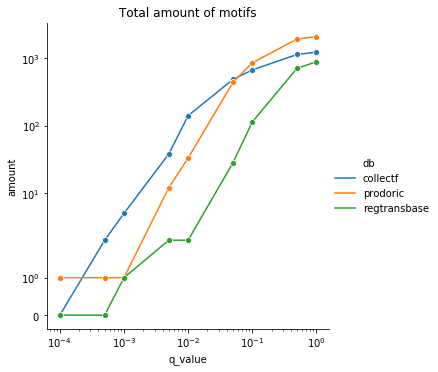

In [419]:
sns.relplot(data=strands_stats_df.query('strand == "both"'), x='q_value', y='amount', hue='db', kind='line', marker='o')
plt.xscale('log')
plt.yscale('symlog')
plt.title('Total amount of motifs')
plt.show()

Действительно, количество мотивов резко падает со снижением порога q-value.

Теперь посмотрим на количество мотивов в зависимости от цепи.

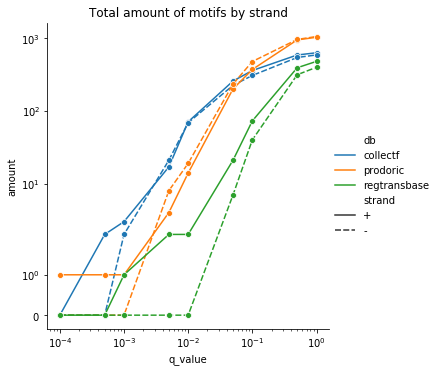

In [420]:
sns.relplot(data=strands_stats_df.query('strand != "both"'), x='q_value', y='amount', hue='db', style='strand', kind='line', marker="o")
plt.xscale('log')
plt.yscale('symlog')
plt.title('Total amount of motifs by strand')
plt.show()

На больших порогах q-value нет какой-то особой разницы в цепи. При снижении порога для разных баз случается по-разному: у одних начинает немного преобладать "+" цепь, у других "-". Но с падением порога ниже 1Е-3 начинает преобладать "+" цепь (но там вообще мало мотивов).

Теперь посмотрим на доли цепей.

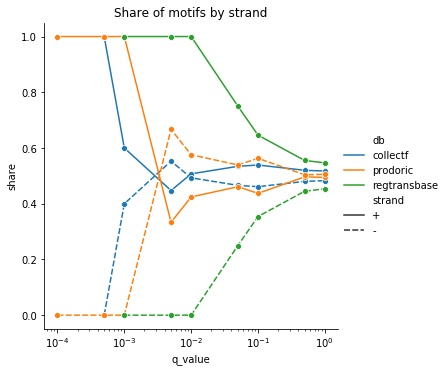

In [421]:
sns.relplot(data=strands_stats_df.query('strand != "both"'), x='q_value', y='share', hue='db', style='strand', kind='line', marker="o")
plt.xscale('log')
plt.title('Share of motifs by strand')
plt.show()

Кажется, что ~~ничего непонятно~~ "+" цепь преобладает. Давайте проведём биномиальный тест на определение того, насколько значимо доля "+" (и "-") отклоняется в бОльшую сторону от 0.5. Проводить z-test на сравнение двух пропорций не очень валидно из-за маленьких выборок при маленьких значениях q-value и из-за того, что мы определяли долю как 0, если наблюдений нет. Не будем делать поправку на множественное тестирование, так как неохота и это не спасёт ситуацию (смотрите далее).

Подсчитаем p-value.

In [512]:
plus_pvals = list()
for plus, total in zip(strands_stats_df.query('strand == "+"')['amount'].array,
                        strands_stats_df.query('strand == "both"')['amount'].array):
    plus_pvals.append(binom_test(plus, n=total, p=0.5, alternative='greater'))

minus_pvals = list()
for plus, total in zip(strands_stats_df.query('strand == "-"')['amount'].array,
                        strands_stats_df.query('strand == "both"')['amount'].array):
    minus_pvals.append(binom_test(plus, n=total, p=0.5, alternative='greater'))

Соберём датафрейм из p-value.

In [513]:
strands_binom_test = pd.DataFrame({'q_value': strands_stats_df.query('strand == "both"')['q_value'],
                                  'db': strands_stats_df.query('strand == "both"')['db'],
                                  'plus': plus_pvals,
                                  'minus': minus_pvals})

In [527]:
strands_binom_test.head()

q_value            db  plus  minus
2    0.0001      collectf  1.00    1.0
5    0.0001      prodoric  0.50    1.0
8    0.0001  regtransbase  1.00    1.0
11   0.0005      collectf  0.25    1.0
14   0.0005      prodoric  0.50    1.0

Преобразуем датафрейм для построения графиков.

In [519]:
strands_binom_test2 = strands_binom_test.melt(id_vars=['q_value', 'db'], value_vars=['plus', 'minus'], var_name='strand', value_name='p_value')

In [526]:
strands_binom_test2.head()

q_value            db strand  p_value
0   0.0001      collectf   plus     1.00
1   0.0001      prodoric   plus     0.50
2   0.0001  regtransbase   plus     1.00
3   0.0005      collectf   plus     0.25
4   0.0005      prodoric   plus     0.50

Построим графики p-value.

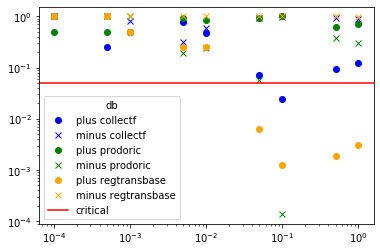

In [529]:
for db, color in zip(['collectf', 'prodoric', 'regtransbase'], ['blue', 'green', 'orange']):
    for strand, marker in zip(['plus', 'minus'], ['o', 'x']):
        plt.plot(strands_binom_test2.dropna().query(f'db == "{db}" and strand == "{strand}"')['q_value'],
                 strands_binom_test2.dropna().query(f'db == "{db}" and strand == "{strand}"')['p_value'],
                 marker, label=strand + ' ' + db, color=color)
plt.axhline(0.05, color='red', label='critical')
plt.legend(title='db')
plt.xscale('log')
plt.yscale('log')

В общем случае не можем отвергнуть предположение о том, что мотивы безразличны к цепи. Для regtransbase есть некий сдвиг в сторону "+"-цепи на небольших q-value, но потом просто нет наблюдений.

Делаем заключение, что в нашей ситуации нет предпочтения цепи.

#### 6.2.2. Точный тест Фишера на совпадение мотивов и начал CDS.

Для начала надо отсортировать аннотацию CDS и мотивы.

In [335]:
%%bash
sort -k4,4n 26_output_prokka.GFF___FASTA/26.prokka_cds.gff > 26_output_prokka.GFF___FASTA/26.prokka_cds.sorted.gff

In [336]:
%%bash
sort -k4,4n motif_search/fimo_collectf.gff.txt > motif_search/fimo_collectf.sorted.gff
sort -k4,4n motif_search/fimo_collectf_qvalue_1E-02.gff > motif_search/fimo_collectf_qvalue_1E-02.sorted.gff
sort -k4,4n motif_search/fimo_collectf_qvalue_5E-03.gff > motif_search/fimo_collectf_qvalue_5E-03.sorted.gff

sort -k4,4n motif_search/fimo_prodoric.gff.txt > motif_search/fimo_prodoric.sorted.gff
sort -k4,4n motif_search/fimo_prodoric_qvalue_1E-02.gff > motif_search/fimo_prodoric_qvalue_1E-02.sorted.gff
sort -k4,4n motif_search/fimo_prodoric_qvalue_5E-03.gff > motif_search/fimo_prodoric_qvalue_5E-03.sorted.gff

sort -k4,4n motif_search/fimo_regtransbase.gff.txt > motif_search/fimo_regtransbase.sorted.gff
sort -k4,4n motif_search/fimo_regtransbase_qvalue_1E-02.gff > motif_search/fimo_regtransbase_qvalue_1E-02.sorted.gff
sort -k4,4n motif_search/fimo_regtransbase_qvalue_5E-03.gff > motif_search/fimo_regtransbase_qvalue_5E-03.sorted.gff

Затем надо из аннотации сделать отрезки [-200, 100] относительно начала CDS. Для этого нужен специальный файл с размером генома для нашей разметки.

In [534]:
%%bash
echo -e "strain\t21000" > 26.genome

In [540]:
%%bash
bedtools flank -i 26_output_prokka.GFF___FASTA/26.prokka_cds.sorted.gff -g 26.genome -l 200 -r 0 \
| bedtools slop -i - -l 0 -r 100 -g 26.genome > 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff

Теперь проведём точный тест Фишера для каждого набора мотивов с разными порогами q-value.

##### 6.2.2.1. q-value &le; 1

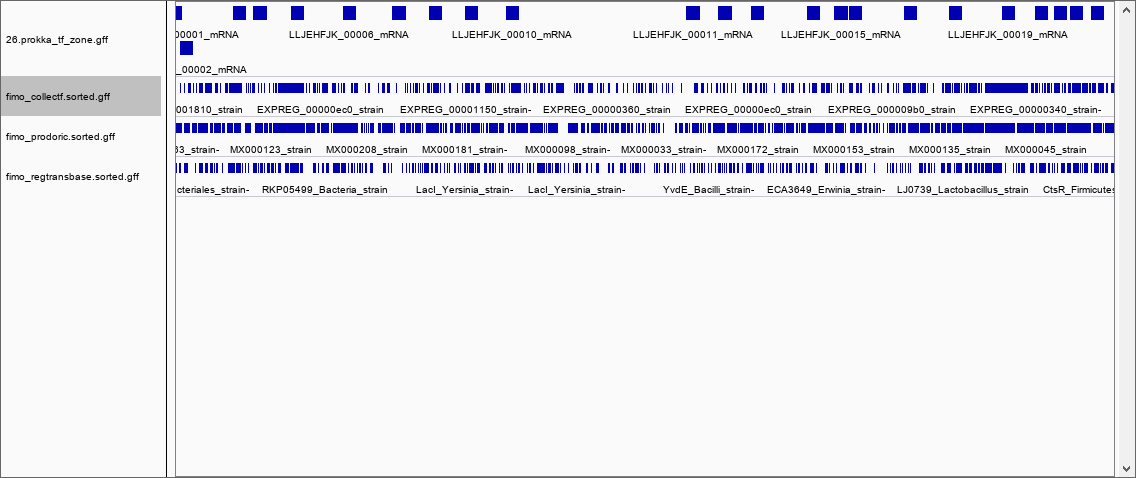

In [576]:
display(Image('motifs_vs_start_full.png'))

Какая-то каша.

In [546]:
%%bash
bedtools fisher -a motif_search/fimo_collectf.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 1222
# Number of db intervals: 23
# Number of overlaps: 602
# Number of possible intervals (estimated): 1222
# phyper(602 - 1, 1222, 1222 - 1222, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 602          | 620          |
# not in -a | 0            | 0            |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	1	1	-nan


In [547]:
%%bash
bedtools fisher -a motif_search/fimo_prodoric.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 2090
# Number of db intervals: 23
# Number of overlaps: 923
# Number of possible intervals (estimated): 2090
# phyper(923 - 1, 2090, 2090 - 2090, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 923          | 1167         |
# not in -a | 0            | 0            |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	1	1	-nan


In [548]:
%%bash
bedtools fisher -a motif_search/fimo_regtransbase.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 880
# Number of db intervals: 23
# Number of overlaps: 342
# Number of possible intervals (estimated): 880
# phyper(342 - 1, 880, 880 - 880, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 342          | 538          |
# not in -a | 0            | 0            |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	1	1	-nan


Ни для какого из наборов мотивов не найдено значимой связи между размещением мотивов и началами CDS. Тем более, что мотивов вне начал CDS больше, чем пересекающихся с ними.

##### 6.2.2.2 q-value &le; 1E-2

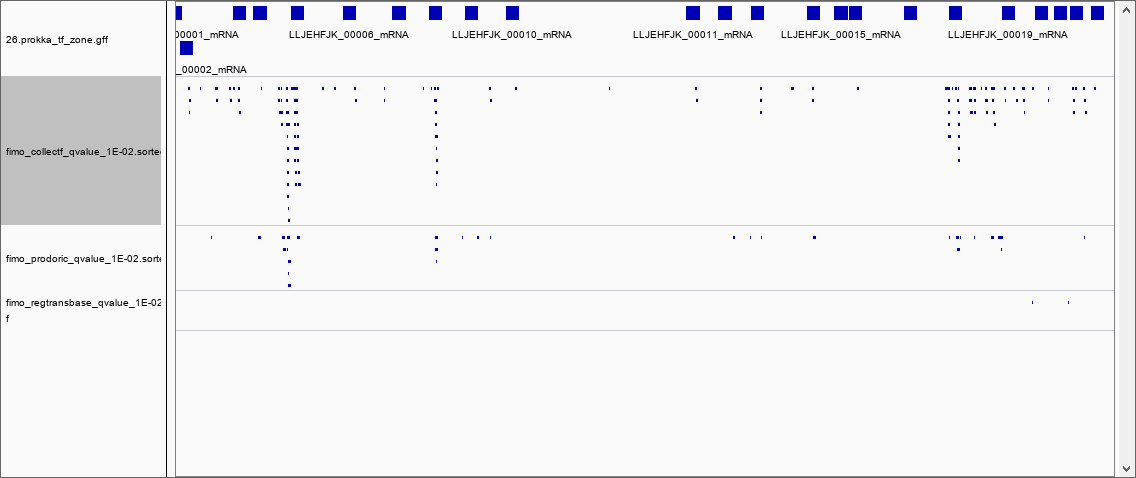

In [577]:
display(Image('motifs_vs_start_1E-02.png'))

Действительно похоже на колокализацию.

In [550]:
%%bash
bedtools fisher -a motif_search/fimo_collectf_qvalue_1E-02.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 139
# Number of db intervals: 23
# Number of overlaps: 74
# Number of possible intervals (estimated): 139
# phyper(74 - 1, 139, 139 - 139, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 74           | 65           |
# not in -a | 0            | 0            |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	1	1	-nan


In [552]:
%%bash
bedtools fisher -a motif_search/fimo_prodoric_qvalue_1E-02.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 32
# Number of db intervals: 23
# Number of overlaps: 15
# Number of possible intervals (estimated): 62
# phyper(15 - 1, 32, 62 - 32, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 15           | 17           |
# not in -a | 8            | 22           |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
0.97257	0.082918	0.12061	2.426


In [553]:
%%bash
bedtools fisher -a motif_search/fimo_regtransbase_qvalue_1E-02.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 2
# Number of db intervals: 22
# Number of overlaps: 0
# Number of possible intervals (estimated): 66
# phyper(0 - 1, 2, 66 - 2, 22, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 0            | 2            |
# not in -a | 22           | 42           |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
0.44103	1	0.54872	0.000


Аналогично, не нашли ничего интересного. Только вот в regtransbase стало как-то подозрительно много участков генома, которые не попадают ни в один из наборов отрезков, поэтому он съехал. В prodoric что-то близится к значимому порогу для правостороннего теста. Как это интерпретировать, нам непонятно, надо смотреть на двусторонний тест.

##### 6.2.2.3. q-value &le; 5E-3

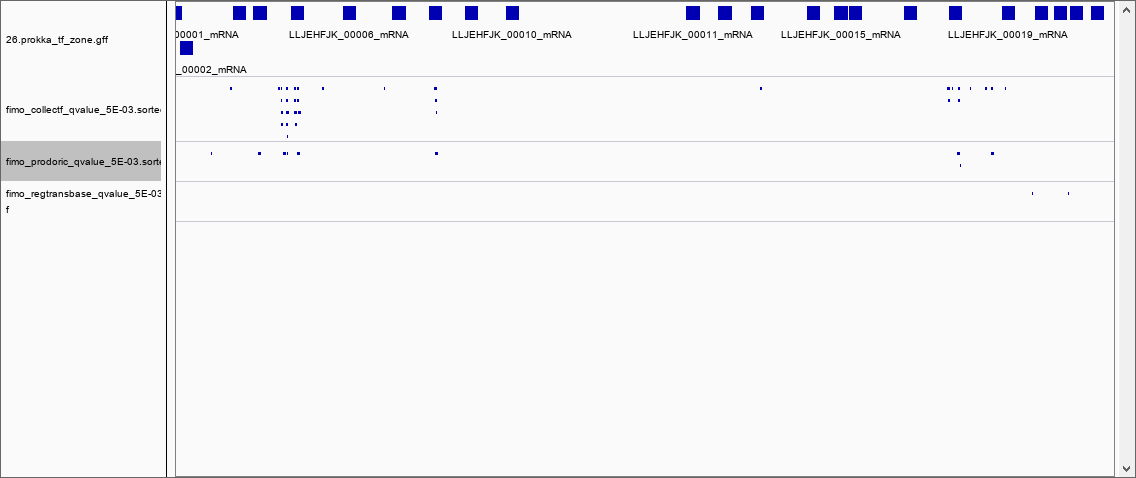

In [579]:
display(Image('motifs_vs_start_5E-03.png'))

Между 4 и 5 CDS есть блок мотивов CollecTF (мотивы Fur и NikR) и даже немного Prodoric (CodY и SarA), которые не попадают в начало CDS.

In [554]:
%%bash
bedtools fisher -a motif_search/fimo_collectf_qvalue_5E-03.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 38
# Number of db intervals: 23
# Number of overlaps: 17
# Number of possible intervals (estimated): 62
# phyper(17 - 1, 38, 62 - 38, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 17           | 21           |
# not in -a | 6            | 18           |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
0.96851	0.096401	0.1773	2.429


In [555]:
%%bash
bedtools fisher -a motif_search/fimo_prodoric_qvalue_5E-03.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 11
# Number of db intervals: 23
# Number of overlaps: 5
# Number of possible intervals (estimated): 62
# phyper(5 - 1, 11, 62 - 11, 23, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 5            | 6            |
# not in -a | 18           | 33           |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
0.83588	0.38012	0.73204	1.528


In [556]:
%%bash
bedtools fisher -a motif_search/fimo_regtransbase_qvalue_5E-03.sorted.gff -b 26_output_prokka.GFF___FASTA/26.prokka_tf_zone.gff -g 26.genome

# Number of query intervals: 2
# Number of db intervals: 22
# Number of overlaps: 0
# Number of possible intervals (estimated): 66
# phyper(0 - 1, 2, 66 - 2, 22, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 0            | 2            |
# not in -a | 22           | 42           |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
0.44103	1	0.54872	0.000


Та же самая ситуация здесь. Мотивы встречаются чаще вне начал CDS, чем их пересекают.

#### 6.2.3 Выводы по колокализации мотивов и начал CDS

Можно сказать, что что-то значит, а можно сказать, что ничего не значит (тем более, что мы смотрели в окрестности начала CDS, а не TSS). В данных есть много повторяющихся и перекрывающихся мотивов Fur и немного перекрывающихся с ними мотивов NikR (оба AT-богатые с повторами), они могут искажать реальное число мотивов.

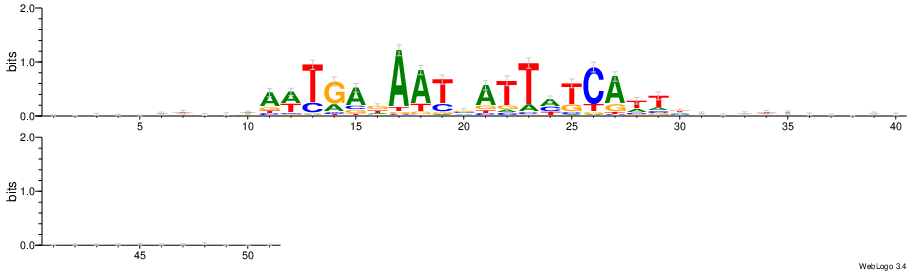

In [575]:
display(Image('fur_motif.png'))
display(HTML("Мотив Fur"))

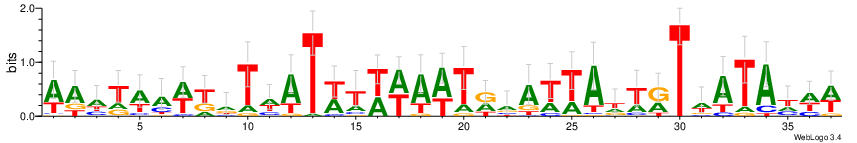

In [573]:
display(Image('nikr_motif.png'))
display(HTML("Мотив NikR"))

Кстати, эти два мотива ещё и хорошо выравниваются с помощью TOMTOM:

Статистика|Значение
---|---
p-value|1.67e-05
E-value|1.41e-03
q-value|1.33e-03

Причём, обратно-комплементарно.

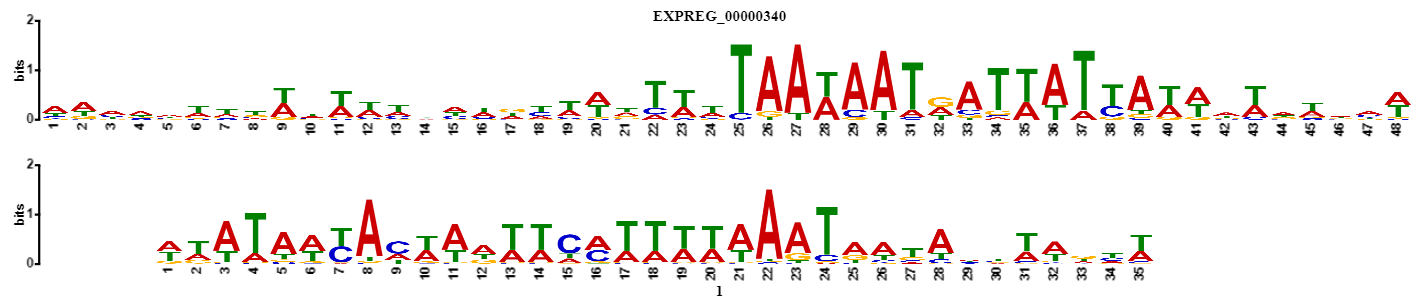

In [606]:
display(Image('motif_alignment.png'))

### 6.3. Выводы по поиску мотивов TF

Статистически не удалось показать ассоциацию мотивов TF и начал CDS, но визуально мы всё равно видим хорошо поддержанные разными источниками мотивы около начал CDS. Будем считать, что совмещение функций сайтов связыания TF и лежащих рядом с ними генов позволит определить возможные функциональные сайты.

## 7. Анализ функций продуктов CDS

В итоге из Blast2GO мы получили большую таблицу с аннотацией функций и других фич CDS. К сожалению, бесплатная версия Blast2GO не даёт экспортировать результаты в gff, поэтому у нас будет просто плоская таблица. Таблицу можно посмотреть ниже и получить по [ссылке](blast2go/prokka_results/blast2go_go_table.txt).

In [870]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-870-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [898]:
annotation = pd.read_csv('blast2go/prokka_results/blast2go_go_table.txt', sep='\t')
annotation = annotation.drop('Unnamed: 0', axis=1)
annotation['CDS_number'] = np.arange(1, 24)
new_columns = pd.Series(list(annotation.columns[-1:]) + list(annotation.columns[1: 2]) + list(annotation.columns[0: 1]) + list(annotation.columns[2: -1]))
annotation = annotation.loc[:, new_columns]

In [899]:
display(annotation)

CDS_number                       SeqName  \
0   1           CDS_strain_56-275(plus)        
1   2           CDS_strain_301-1420(plus)      
2   3           CDS_strain_1485-1911(plus)     
3   4           CDS_strain_1933-2485(plus)     
4   5           CDS_strain_2774-3914(plus)     
5   6           CDS_strain_3924-5022(plus)     
6   7           CDS_strain_5018-5771(plus)     
7   8           CDS_strain_5834-6605(plus)     
8   9           CDS_strain_6627-7518(plus)     
9   10          CDS_strain_7546-11491(plus)    
10  11          CDS_strain_11551-12250(plus)   
11  12          CDS_strain_12262-12952(plus)   
12  13          CDS_strain_12983-14219(plus)   
13  14          CDS_strain_14224-14866(plus)   
14  15          CDS_strain_14831-15143(plus)   
15  16          CDS_strain_15160-16303(plus)   
16  17          CDS_strain_16380-17175(plus)   
17  18          CDS_strain_17374-18574(plus)   
18  19          CDS_strain_18548-19286(plus)   
19  20          CDS_strain_19286-19691(plus)   
20  21          CDS_strain_19703-20003(plus)   
21  22          CDS_strain_20059-20545(plus)   
22  23          CDS_strain_20531-20780(plus)   

                                      Tags  \
0   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
1   [INTERPRO, BLASTED]                      
2   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
3   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
4   [INTERPRO, BLASTED]                      
5   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
6   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
7   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
8   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
9   [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
10  [INTERPRO, BLASTED, MAPPED]              
11  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
12  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
13  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
14  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
15  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
16  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
17  [INTERPRO, BLASTED, MAPPED]              
18  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
19  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
20  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
21  [INTERPRO, BLASTED, MAPPED, ANNOTATED]   
22  [INTERPRO, BLASTED]                      

                                                           Description  \
0   cobaltochelatase subunit CobN                                        
1   iron ABC transporter substrate-binding protein                       
2   tRNA (N6-threonylcarbamoyladenosine(37)-N6)-methyltransferase TrmO   
3   flavin reductase family protein                                      
4   iron ABC transporter substrate-binding protein                       
5   iron ABC transporter permease                                        
6   ABC transporter ATP-binding protein                                  
7   nitrogenase reductase                                                
8   class I SAM-dependent methyltransferase                              
9   cobaltochelatase subunit CobN                                        
10  ABC transporter substrate-binding protein                            
11  ABC transporter substrate-binding protein                            
12  cobaltochelatase subunit CobN                                        
13  MotA/TolQ/ExbB proton channel family protein                         
14  DUF2149 domain-containing protein                                    
15  AAA domain-containing protein                                        
16  putative cobaltochelatase                                            
17  membrane protein                                                     
18  YggS family pyridoxal phosphate-dependent enzyme                     
19  cell division protein SepF                                           
20  YggT family protein                                                  
21  DivIVA domain-containing protein                                     
22  CopG family transcriptional regulator   

### 7.1. Проверка аннотаций на консистентность и реаннотация

Пойдём по порядку.

**CDS 1** предсказана как субъединица CobN хелатазы кобальта или субъединица хелатазы магния. Первая участвует в синтезе кобаламина (B<sub>12</sub>), а вторая &mdash; в синтезе бактериохлорофилла. Такая двойная аннотация была как в BLAST, так и в PANTHER. Насколько нам известно, Thermanaerobacterales не фототрофы, а поэтому им не нужен порфирин. Значит, это должна быть хелатаза кобальта.

**CDS 2** не получилось аннотировать по GO, лишь вывести название из BLAST: субстрат-связывающий белок ABC-транспортера железа. Беглый взгляд в Uniprot показал, что нет ни одной записи в UniProtKB с таким названием, белки обычно с уровнем аннотации 1-2 из 5. Зато InterPro Scan предсказал много чего. Так, в InterPro по PFAM был предсказан ABC transporter periplasmic binding domain ([IPR002491](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002491/)), который у Грам+ бактерий связывается с мембраной с помощью ацилирования цистеина. Системы транспорта железа и кобаламина очень похожи и, видимо,произошли из одного источника. GENE3D не удалось найти в интернете, а PANTHER предсказала ferrichrome-binding periplasmic protein related ([PTHR30535:SF34](http://pantherdb.org/panther/family.do?clsAccession=PTHR30535:SF34)). Prosite нашёл сайт присоединения липида([PS51257](https://prosite.expasy.org/PS51257)). PHOBIUS предсказал несколько сигнальных пептидов, а показания SignalP противоречивые: TM-версия предсказала Грам+, noTM-версия предсказала Грам-, а ещё и эукариотичность белка. В целом, можно сказать, что отношение к транспорту железа поддерживается сильнее, чем отношение белка к транспорту кобаламина.

**CDS 3** предсказана как tRNA-метилтрансфераза TrmO (или TsaA, или YaeB), которая метилирует 37 аденозин по N6 в антикодоновой петли сериновой тРНК GCU ([ссылка](https://www.ncbi.nlm.nih.gov/pubmed/25063302)). Аннотации из разных источников согласуются между собой.

**CDS 4** предсказана как белок семейства флавин-редуктаз. GO выделил оксидоредуктазную активность и связывание FMN (как из BLAST, так и из InterPro). Аннотация InterPro поддтверждает активность в отношении FMN, поэтому можем заявить, что эта CDS кодирует FMN-оксидоредуктазу.

**CDS 5** аналогична CDS 2, такая же аннотация. У них даже длины похожи: 1119 и 1140.

**CDS 6** аннотирована как пермеаза ABC транспортера железа с гидролазной активностью, участием в трансмембранном транспорте. Интегральный и плазматический белок. Согласно GENE3D и PFAM, этот белок относится к семейству BtuC-подобных пермеаз (в него входят ферменты поглощения кобаламина и дицитрата железа из оперона fec, зависимого от периплазматического связывающего белка) ([IPR000522](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR000522/), [IPR037294](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR037294/)). У фермента предсказано 9 трансмембранных цепей (PHOBIUS и TMHMM), 5 нецитоплазматических доменов (PHOBIUS) и 5 цитоплазматических доменов (PHOBIUS) (в целом, доменная структура согласуется).

**CDS 7** аннотирована как ATP-связывающий белок ABC-транспортера с АТФазной активностью. Предсказано наличие AAA+ АТФазного домена ([IPR003593](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR003593/)), принадлежность к семейству ABC-транспортеров ([IPR003439](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR003439/)) с консервативным доменом ([IPR017871](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR017871/)) и P-петлёй ([IPR027417](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR027417/)). Предсказано наличие coiled coil структуры. В PANTHER семейство [PTHR42734](http://pantherdb.org/panther/familyList.do?searchType=basic&fieldName=1,3,11,12,13,14,23,27,28,25,26&listType=6&fieldValue=PTHR42734) содержит АТФ-связывающие белки систем транспорта кобаламина и различных ионов металлов (железа, цинка, магния).

**CDS 8** описана как редуктаза нитрогеназы (субъединица, NifH, Fe-белок) с трансферазной активностью по аннотации BLAST. В InterPro Scan не были найдены GO terms. Согласно ряду сервисов, данный фермент содержит CobQ/CobB/MinD/ParA нуклеотид-связывающий домен ([IPR002586](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002586/), в том числе участвует в синтезе кобаламина), P-петлевой домен нуклеозидтрифосфатгидролазы ([IPR027417](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR027417/)) и относится к семейству факторов созревания CO дегидрогеназ ([IPR014433](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR014433/), CooC &mdash; АТФ-зависимая никельинзертаза для CODH). CDD тоже свидетельствует в пользу CooC ([cd02034](https://www.ncbi.nlm.nih.gov/Structure/cdd/cd02034)), а именно CooC1. По-видимому, описание BLAST ошиблось в этот раз и это действительно CooC1.

**CDS 9** описана как метилтрансфераза класса I (SAM-домен укладки Россмана). Записи из InterPro и CDD подтверждают эту аннотацию, а PANTHER сужает аннотацию до cyclopropane-fatty-acyl-phospholipid synthase, катализирующую реакцию присоединения метильной группы к ненасыщенной жирной кислоте (в составе фосфолипида) с образованием циклопропанового производного ([PTHR43667](http://pantherdb.org/panther/family.do?clsAccession=PTHR43667)). В целом, это действительно SAM-метилтрансфераза, возможно, образует циклопропановые производные ненасыщенных фосфолипидов.

**CDS 10** аннотирована как хелатаза кобальта или магния. Выделенные семейства InterPro, CDD и PANTHER указывают на хелатазу кобальта (субъединицу CobN), которая участвует в биосинтезе кобаламина.

**CDS 11** описана из BLAST как субстрат-связывающий белок ABC-транспортера с разнообразными функциями: связывание ДНК и регуляция транскрипции, свяызвание цинка, участие в катаболизме пептидогликанов с активностью N-ацетилмурамоил-L-аланинамидазы (или пептидогликанамидогидролаза, разрезает компоненты клеточной стенки). Часть аннотаций поддерживает принадлежность к амидазам ([IPR036582](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR036582/), [IPR012854](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR012854/)), но есть поддержка для периплазматического связывающего белка ABC-транспортера ([IPR002491](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002491/), [PTHR30535](http://pantherdb.org/panther/familyList.do?searchType=basic&fieldName=1,3,11,12,13,14,23,27,28,25,26&listType=6&fieldValue=PTHR30535)). В белке предсказаны сигнальные пептиды и нецитоплазматический домен (PHOBIUS). В общем, странно, непонятно, что выбрать.

**CDS 12** аннотирована как ещё один субстрат-связывающий (периплазматический) белок ABC-транспортера, локализованный в мембране (но без предсказанных трансмембранных спиралей). 

**CDS 13** ещё одна кобальтохелатаза (CobN) или магнийхелатаза (ChlN) с предсказанными цитоплазматическим, нецитоплазматическим и трансмембранным доменами. GO terms больше поддерживают ChlN, но какой там синтез хлорофилла.

**CDS 14** аннотирована как потенциальный белковый канал семейства MotA/TolQ/ExbB, встроенный в мембрану. Предсказано 3 трансмембранные цепи, два цитоплазматических и 2 нецитоплазматических домена.

**CDS 15** аннотирован как белок с DUF2149 доменом неизвестной функции. Предсказана 1 трансмембранная спираль и по одному цитоплазматическому и нецитоплазматическому доменам.

**CDS 16** аннотирована как AAA-содержащий белок с АТФ-связывающей и магний-хелатазной активностями. Аннотация как Chll-субъединица хелатазы магния и AAA+ АТФаза поддержана многими источниками. Но CDD указывает на MCM хеликазу ([cd17706](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=350658)), но это эукариотический белок.

**CDS 17** названа предполагаемой кобальтохелатазой, но по GO аннотируется как магнийхелатаза. Интересно, что ряд алгоритмов аннотирует белок как фактор А фон Виллебранда, участвующий в связывании крови ([IPR002035](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002035/), [IPR036465](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR036465/)), но на самом деле, это магнийхелатаза с VWA-доменом ([IPR041702](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR041702/)), а именно ChlD-субъединица магнийхелатазы([PTHR43473](http://pantherdb.org/panther/family.do?clsAccession=PTHR43473)).

**CDS 18** делает какой-то мембранный белок, как вывели из BLAST. У него предсказана coiled coil, трансмембранный домен, нецитоплазматический домен и сигнальные пептиды. Аннотации противоречивы: HlyD-субъединица комплекса секреции гемолизина ([IPR032681](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR032681/)), или компонент YknX системы эффлюкса ([PTHR32347:SF14](http://pantherdb.org/panther/family.do?clsAccession=PTHR32347:SF14), выкачка фактора SdpC). GENE3D аннотирует белок как часть системы эффлюкса.

**CDS 19** аннотирована как пиридоксальфосфат-зависимый (PLP, активная форма витамина B<sub>6</sub>) фермент семейства YggS c функцией связывания PLP. Аннотация InterPro Scan подтверждает, что это pyridoxal phosphate homeostasis protein, фолд которого похож на фолд аланиновой рацемазы ([IPR001608](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR001608/)).

**CDS 20** аннотирована как белок деления SepF, который участвует в образовании септы деления, свяызывая FtsZ. Аннотация InterPro Scan подтверждает это. Этот белок консервативен у Грам+ бактерий ([IPR023052](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR023052/)).

**CDS 21** аннотирована как белок семейства YggT, входящий в состав мембраны. Предсказано 2 трансмембранные спирали, два нецитоплазматических и один цитоплазматический домены. Семейство [IPR003425](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR003425/) включает в себя как субъединицу CCB3 кофакторного комплекса С (участвует в синтезе цитохрома с у бактерий и цитохрома b6 у растений), так и некий неописанный белок YggT. В PANTHER было найдено семейство белков-гомологов YlmG ([PTHR33219](http://pantherdb.org/panther/family.do?clsAccession=PTHR33219)). В хлоропластах этот белок отвечает за распределение нуклеоидов, а в цианобактериях &mdash; за форму нуклеоида и клеточное деление ([ссылка](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2923531/)).

**CDS 22** аннотирована как DivIVA-содержащий белок, участвующий в делении клетки. Этот белок участвует в образовании септы деления ([IPR007793](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR007793/)) и имеет coiled coil (а предсказано целых 2).

**CDS 23** аннотирована как транскрипционный регулятор семейства CopG (RepA). Аннотация InterPro Scan сужает это семейство до белка NikR, регулирующего поглощение никеля (репрессор).

Как-то жутко получается, нашли фотосинтетические белки, хотя единственными фототрофами из Firmicutes являются Heliobacteria. Непонятно, что с этим делать. Зато кажется, что нашли опероны из нескольких белков ABC-транспортёра, идущих подряд.

### 7.2. Коанализ аннотации и возможных мотивов связывания TF

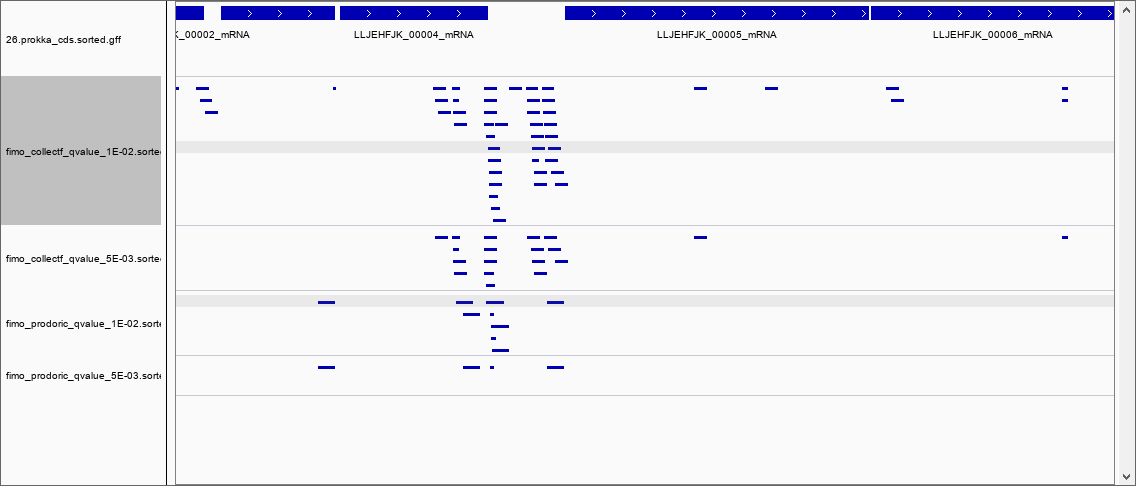

In [900]:
display(Image('fur_operon_5-7.png'))

Было обнаружено много попаданий мотива Fur (ferric uptake regulator protein) перед CDS 5. CDS 5-7 относятся к белкам ABC-транспортера с возможной активностью в отношении железа. Fur &mdash; репрессор, подавляет поглощение железа при высоком его уровне в клетке ([ссылка](https://en.wikipedia.org/wiki/Ferric_uptake_regulator_family)). Здесь вся картинка сходится, нашли целый оперон. Мотив получен из базы CollecTF. Также из базы Prodoric там находится мотив связыания CodY &mdash; плейотропного репрессора генов, которые отвечают за переход клеток из log-фазы в стационарную фазу. Этот белок связывается с GTP и при низком его уровне (недостатке нутриентов) перестаёт подавлять гены ([ссылка](https://www.uniprot.org/uniprot/P39779)). Вполне возможно, что CodY может подавлять поглощение железа при большом достатке нутриентов.

Ещё подозрительна колокализация мотивов Fur, CodY и NikR (репрессор поглощения никеля, [ссылка](https://www.uniprot.org/uniprot/P0A6Z6)) рядом с CDS 18 (белок системы эффлюкса) и CDS 19 (PLP-связывающий белок).

Интересно, что перед CDS 22 (ген NikR) нет сильно достоверных мотивов NikR.

Обсуждение остальных мотивов сильно спекулятивно: при фильтрации по q-value остались в основном мотивы Fur и NikR, которые попадают и в CDS, и между CDS.

Btw, мотив CodY содержит много А и Т, идущих подряд. Вполне возможно, что обнаружение мотива &mdash; артефакт.

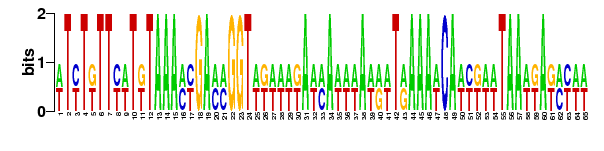

In [904]:
display(Image('cody.png'))
display(HTML('CodY'))

А ещё CodY неплохо выравнивается с Fur:

Величина|Значение
---|---
p-value|2.64e-04
E-value|1.30e-01
q-value|8.67e-02

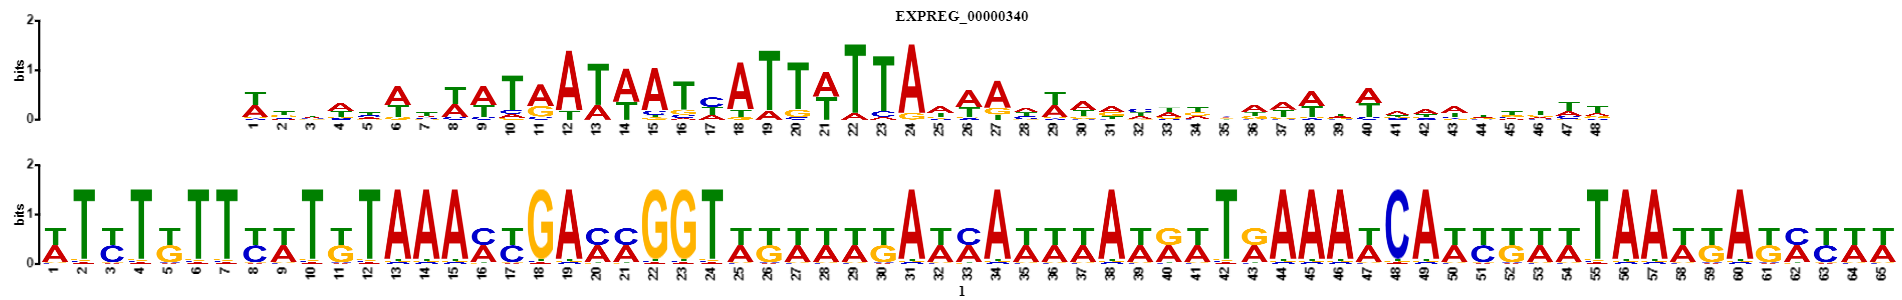

In [905]:
display(Image('cody_vs_fur.png'))

## 8. Обсуждение и впечатления

У нас получилось хорошо аннотировать данный кусок генома бактерии: найти CDS, описать их функции, собрать оперон и показать сайты связывания TF. Интересно, что PROKKA и RAST несколько различаются в определении CDS. Blast2GO &mdash; мощный инструмент для аннотации функций CDS, который позволяет просто тыкать на кнопки и получать приличные результаты. Однако случаются неоднородности между описанием белка, выведеным из названий хитов BLAST, между их GO-аннотациями и найденными доменами из InterPro Scan. Также удивило огромное количество попаданий ряда мотивов связывания на слабом уровне q-value. 

Очень сильно смущает аннотация магнийхелатаз в данном организме (он же должен быть хемотрофом), которые относятся к пути образования хлорофилла. В целом, в данном отрезке собраны в основном мембранные белки или белки, участвующие в транспорте веществ, но также и другие белки (метилтрансфераза фосфолипидов, поглощение никеля, деление клетки). Кажется, что функционально белки перемешаны на данном участке.

Понравилось использовать разные биоинформатические инструменты из Python. А ещё нашли баг в bedtools fisher с одной из опций (здесь не использовали). А вот Blast2GO Basic подкачал: в бесплатной версии многие функции урезаны, в том числе вывод в формате gff.